In [1]:

# good references
# https://www.tensorflow.org/tutorials/load_data/pandas_dataframe
# https://www.tensorflow.org/tutorials/load_data/csv

import os

from collections import defaultdict

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import Input
from keras.utils import to_categorical

tf.__version__

2023-09-05 08:38:51.675701: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-05 08:38:51.748592: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-05 08:38:51.751019: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-05 08:38:52.637158: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'2.13.0'

In [2]:
# TODO there is a numpy util to get files from within tgz's and zips
##!curl -s 'https://storage.googleapis.com/0x19f.com/media/kaggle-mlb-pitch-data-2015-2018.tgz' | tar xz

BASEBALL_FILES_BASE = os.getcwd() + "/kaggle-mlb-pitch-data-2015-2018/"
BASEBALL_FILES_BASE = BASEBALL_FILES_BASE + "2019_"  # just look at 2019 to speed things up

pitches = pd.read_csv(BASEBALL_FILES_BASE + 'pitches.csv')
atbats = pd.read_csv(BASEBALL_FILES_BASE + 'atbats.csv')

df = pd.merge(pitches, atbats, how='inner', on='ab_id')

df = df[[
    # situation stuff
    "ab_id", "inning", "top", "outs", "on_1b", "on_2b", "on_3b",

    # matchup
    "pitcher_id", "p_throws", "batter_id", "stand",

    # specific pitch state
    "pitch_num", "b_count", "s_count",
    # TODO need to add running total of pitches for the current pitcher, and maybe strike percentage
    # TODO add the previous n pitches before and their code outcome
        
    # this is the label we're trying to predict
    "code",
    "pitch_type",
    # TODO also make the label have the location. not just FF (fourseam fastball, but also high inside)
]]

# get appropriate types. 
# TODO prob can use a schema on the CSV read to get only the columns we're after, alias them to be more
#      useful, and cast to the right type
# TODO consider to_ordinal for cumulative things maybe? inning, outs, pitch_num, b_count, s_count

# TODO there is a numpy util to get files from within tgz's and zips
##!curl -s 'https://storage.googleapis.com/0x19f.com/media/kaggle-mlb-pitch-data-2015-2018.tgz' | tar xz

BASEBALL_FILES_BASE = os.getcwd() + "/kaggle-mlb-pitch-data-2015-2018/"
BASEBALL_FILES_BASE = BASEBALL_FILES_BASE + "2019_"  # just look at 2019 to speed things up


pitches = pd.read_csv(BASEBALL_FILES_BASE + 'pitches.csv')
atbats = pd.read_csv(BASEBALL_FILES_BASE + 'atbats.csv')

df = pd.merge(pitches, atbats, how='inner', on='ab_id')

df = df[[
    # situation stuff
    "ab_id", "inning", "top",  
    
    # would get baserunner stuff but these were all zero.
    #"on_1b", "on_2b", "on_3b",

    # matchup
    "pitcher_id", "p_throws", "batter_id", "stand",

    # TODO add catcher, team
    # TODO need to add running total of pitches for the current pitcher, and maybe strike percentage
    # TODO add the previous n pitches before and their code outcome
    
    # specific pitch state, this becomes situation and is then dropped
    "pitch_num", "b_count", "s_count", "outs",      
    
    # this is the label we're trying to predict
    # TODO also make the label have the location, not just FF (but also high inside)
    "pitch_type",
]]

# remove anything without values, hard to have defaults
df = df.dropna()

# set the appropriate types. 
TYPE_DICT = {
    # string features
    'p_throws': 'string',
    'stand': 'string',

    # small card numeric features and player ids: treat as strings to avoid norming with mean
    'top': 'string',
    'inning': 'string',
    'pitch_num': 'string', 
    'pitcher_id': 'string', 
    'batter_id': 'string',
}
df = df.astype(TYPE_DICT)


# add the pitch count sitaution, concat as an int8 array to loose the decimals,
# and then convert to a string so we can one_shot encode it too. 
df["situation"] = df[["b_count", "s_count", "outs"]].astype("int8").to_numpy().tolist()
df['situation'] = df['situation'].astype("string")


# finally, remove pitch_type and ab_id and stuff already in "situation" 
# because we dont need them at this point
df = df.drop(['ab_id', 'b_count', 's_count', "outs"], axis=1)


# TODO remove this truncation when solid
df = df.truncate(after=60*1000)

# ok, ready to split into features and labels. pitch_features is a copy
# of the df source, but we drop the label feature.
pitch_features = df.copy()
pitch_features.pop("pitch_type")

# the labels we process using a lookup to normalize to one_hot encoding   
all_pitch_types = np.unique(df['pitch_type'].unique())
pitch_type_lookup = layers.StringLookup(vocabulary=all_pitch_types, output_mode='one_hot')
pitch_labels = pitch_type_lookup(df.pitch_type)

print(pitch_features.info())
print(pitch_features.shape)

pitch_features.head()

<class 'pandas.core.frame.DataFrame'>
Index: 59733 entries, 0 to 60000
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   inning      59733 non-null  string
 1   top         59733 non-null  string
 2   pitcher_id  59733 non-null  string
 3   p_throws    59733 non-null  string
 4   batter_id   59733 non-null  string
 5   stand       59733 non-null  string
 6   pitch_num   59733 non-null  string
 7   situation   59733 non-null  string
dtypes: string(8)
memory usage: 4.1 MB
None
(59733, 8)


2023-09-05 08:39:01.587675: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


,inning,top,pitcher_id,p_throws,batter_id,stand,pitch_num,situation
0,1.0,1.0,571666,R,594777,L,1.0,"[0, 0, 0]"
1,1.0,1.0,571666,R,545361,R,1.0,"[0, 0, 1]"
2,1.0,1.0,571666,R,545361,R,2.0,"[0, 0, 1]"
3,1.0,1.0,571666,R,545361,R,3.0,"[0, 1, 1]"
4,1.0,1.0,571666,R,545361,R,4.0,"[1, 1, 1]"


In [3]:
## TODO refactor this into a library, it is also in titanic.ipynb

# attempts to (eventually) preprocess a dataframe of features
# returns all of the collected inputs and preprocessed features 
def process_dataframe_inputs(feature_df):

  # first we walk through each feature in the dataframe, make an input for it,
  # normalize it using the feature_df data, then collect it into lists of
  # inputs and preprocessed inputs, respectively

  input_layers, preprocessed_inputs  = [], []
  for name, col in feature_df.items():

    # TODO do this with log()
    print("processing %s ..." % name)

    # convert to tensorflow types. this is straightforward except 
    # for objects, treat them as strings.
    dtype_str = str(col.dtype) if col.dtype != object else "string"
    cur_dtype = tf.as_dtype(dtype_str)
    cur_input = tf.keras.Input(shape=(1,), name=name, dtype=cur_dtype)
    input_layers.append(cur_input)  

    if cur_dtype == tf.string:
      lookup = layers.StringLookup(vocabulary=np.unique(col))    
      norm = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())
      normalized_input = norm(lookup(cur_input))
      preprocessed_inputs.append(normalized_input)

    else:
      norm = layers.Normalization(axis=None)
      norm.adapt(col)
      normalized_input = norm(cur_input)
      preprocessed_inputs.append( normalized_input )

  # prepare the return values by concatentating the preprocessed inputs
  # and creating a model for which they serve as outputs.
  # 
  # returns the input layers and the processed_inputs, respectively

  preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)
  preprocessing_model = tf.keras.Model(input_layers, preprocessed_inputs_cat)
  preprocessed_inputs = preprocessing_model(input_layers)

  return input_layers, preprocessed_inputs


In [4]:
input_layers, preprocessed_inputs = process_dataframe_inputs(pitch_features)

seqential_hidden_model = tf.keras.Sequential([
  layers.Dropout(0.2),
  # layers.Dense(512, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(32, activation="relu"),
  layers.Dense(len(pitch_type_lookup.get_vocabulary()), activation="softmax"),
])
result = seqential_hidden_model(preprocessed_inputs)
pitch_model = tf.keras.Model(input_layers, result)
pitch_model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])


processing inning ...
processing top ...
processing pitcher_id ...
processing p_throws ...
processing batter_id ...
processing stand ...
processing pitch_num ...
processing situation ...


In [5]:

pitch_features_dict = {
  name: np.array(value) for name, value in pitch_features.items()
}
# TODO add validation_split=0.33, 
hist = pitch_model.fit(x=pitch_features_dict, y=pitch_labels, validation_split=0.33, epochs=30, batch_size=10*1000)


Epoch 1/30
5/5 [==============================] - 2s 168ms/step - loss: 2.3553 - accuracy: 0.2355 - val_loss: 2.2885 - val_accuracy: 0.3723
Epoch 2/30
5/5 [==============================] - 0s 80ms/step - loss: 2.2451 - accuracy: 0.3682 - val_loss: 2.1638 - val_accuracy: 0.3745
Epoch 3/30
5/5 [==============================] - 0s 78ms/step - loss: 2.1106 - accuracy: 0.3692 - val_loss: 2.0213 - val_accuracy: 0.3745
Epoch 4/30
5/5 [==============================] - 0s 75ms/step - loss: 1.9810 - accuracy: 0.3692 - val_loss: 1.9188 - val_accuracy: 0.3745
Epoch 5/30
5/5 [==============================] - 0s 80ms/step - loss: 1.9088 - accuracy: 0.3692 - val_loss: 1.8689 - val_accuracy: 0.3745
Epoch 6/30
5/5 [==============================] - 0s 93ms/step - loss: 1.8683 - accuracy: 0.3693 - val_loss: 1.8553 - val_accuracy: 0.3773
Epoch 7/30
5/5 [==============================] - 0s 84ms/step - loss: 1.8493 - accuracy: 0.3779 - val_loss: 1.8241 - val_accuracy: 0.3754
Epoch 8/30
5/5 [==========

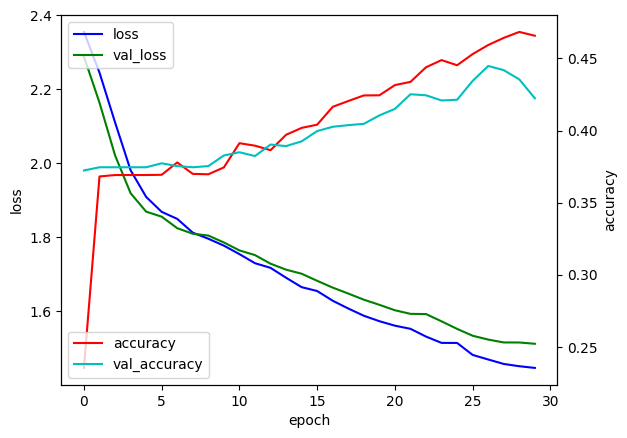

In [20]:

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

colors_iter = iter(mcolors.BASE_COLORS.values())

fig, axisLeft = plt.subplots()
axisLeft.set_xlabel("epoch")
axisLeft.set_ylabel("loss")
for val in ["loss", "val_loss"]:
    axisLeft.plot(hist.epoch, hist.history[val], color=next(colors_iter), label=val)
axisLeft.legend(loc='upper left')

axisRight = axisLeft.twinx()
axisRight.set_ylabel("accuracy")
for val in ["accuracy", "val_accuracy"]:
    axisRight.plot(hist.epoch, hist.history[val], color=next(colors_iter), label=val)
axisRight.legend(loc='lower left')

plt.show()
